# Rigol DS1054Z scope interface test harness

https://readthedocs.org/projects/ds1054z/downloads/pdf/stable/

### Import the libraries

In [1]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.signal as sig
import pyvisa as visa
import time
import os
import shutil

### Import local library

In [2]:
import fcn_scope_ds1054z as scope_ix

#### Print documentation - scope setup

In [3]:
help(scope_ix.b_setup_scope)

Help on function b_setup_scope in module fcn_scope_ds1054z:

b_setup_scope(scope_con, lst_ch_active=[True, False, False, False], lst_ac_coupled=[True, True, True, True], lst_ch_scale=[0.5, 1.0, 1.0, 1.0], timebase_scale=0.05, d_trigger_level=0.1, b_single=True)
    Setup Rigol ds1054z to read data from one or more channels
    
    Keyword arguments:
    scope_con -- Connection to scope. Usually
        the value returned from the 'DS1054Z('192.168.1.206')' call.
    lst_ch_active -- List of booleans describing active channels
        (default: [True, False, False, False] which sets only channel 1
        active).
    lst_ac_coupled -- Boolean list describing ac-coupled state for 
        each channel (default: [True, True, True, True], all channels
        set to AC-coupled)
    lst_ch_scale  -- List with channel scale (default: [5.e-1, 1., 1., 1.] volts)
    timebase_scale -- Time scale for data (default: 0.005 seconds)
    d_trigger_level -- Voltage level to trigger scope (default: 

#### Print documentation - trigger setup

In [4]:
help(scope_ix.b_set_trigger)

Help on function b_set_trigger in module fcn_scope_ds1054z:

b_set_trigger(scope_con, d_trigger_level=0.1)
    Set the trigger configuration
    
    Keyword arguments:
    scope_con -- Connection to scope. Usually
        the value returned from the 'DS1054Z('192.168.1.206')' call.
    d_trigger_level -- Voltage level to trigger scope (default: 0.1 volts)
    
    Return values:
    [None]



#### Print documentation - get data

In [5]:
help(scope_ix.d_get_data)

Help on function d_get_data in module fcn_scope_ds1054z:

d_get_data(scope_con, lst_ch_active=[True, False, False, False], timebase_scale=0.05)
    Get data from the scope
    
    Keyword arguments:
    scope_con -- Scope connection handle (Required). Usually
        the value returned from the 'DS1054Z('192.168.1.206')' call.
    lst_ch_active -- List of booleans describing active channels
        (default: [True, False, False, False] which sets only channel 1
        active). This should exactly match the values used to setup the
        scope.
    timebase_scale -- Scope time scale (default: 5e-2)
    
    Return values:
    lst_d_ch -- list of numpy array of values from the scope:
        [np_d_ch1, np_d_ch2, np_d_ch3, np_d_ch4]. If channel
        was not selected for data capture it will be empty ([])



### Verify scope connection

In [6]:
scope = DS1054Z('192.168.1.206')

In [7]:
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


### Setup the test sequence

This test assumes there is a once-per-turn tachometer signal (AC-coupled and amplitude at least 0.3 volts peak to peak) at ~500 RPM on CH1 and a signal on CH2

In [8]:
str_data_prefix = 'test001'
idx_data = 0
d_timebase_scale = 1e-1
d_ch1_scale = 5.e-1

#### Setup the scope for the trial sample acquisition on just channel 1

In [9]:
lst_ch_active = [True, False, False, False]
lst_ch_scale=[5.e-1, 1., 1., 1.]
d_ch1_scale = scope_ix.b_setup_scope(scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
          timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = False)

Acquire the test samples for channel 1

In [10]:
lst_d_ch = scope_ix.d_get_data(scope_con=scope, lst_ch_active = lst_ch_active, 
            timebase_scale=d_timebase_scale)

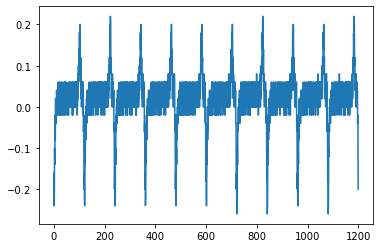

In [11]:
plt.plot(lst_d_ch[0])
assert np.max(lst_d_ch[0])>1e-1, 'Failed to find CH1 signal'
assert lst_d_ch[1].size == 0, 'Failed to return empty CH2 array'
assert lst_d_ch[2].size == 0, 'Failed to return empty CH3 array'
assert lst_d_ch[3].size == 0, 'Failed to return empty CH4 array'

#### Setup the scope for the trial sample acquisition on channel 1 and channel 2

In [12]:
lst_ch_active = [True, True, False, False]
lst_ch_scale=[5.e-1, 2., 1., 1.]
d_ch1_scale = scope_ix.b_setup_scope(scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
          timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = False)

Acquire the test samples for channel 1 and channel 2

In [13]:
lst_d_ch = scope_ix.d_get_data(scope_con=scope, lst_ch_active = lst_ch_active, 
            timebase_scale=d_timebase_scale)

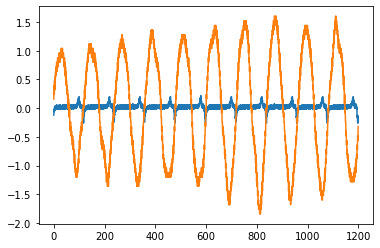

In [14]:
plt.plot(lst_d_ch[0])
plt.plot(lst_d_ch[1])
assert np.max(lst_d_ch[0])>1e-1, 'Failed to find CH1 signal'
assert np.max(lst_d_ch[1])>1e-1, 'Failed to find CH2 signal'
assert lst_d_ch[2].size == 0, 'Failed to return empty CH3 array'
assert lst_d_ch[3].size == 0, 'Failed to return empty CH4 array'

### Test for single-shot triggering

In [15]:
lst_ch_active = [True, False, False, False]
lst_ch_scale=[5.e-1, 1., 1., 1.]
d_ch1_scale = scope_ix.b_setup_scope(scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
          timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = True)